In [1]:
import sklearn 
from sklearn.model_selection import train_test_split #Train/test split 
from sklearn.ensemble import RandomForestClassifier #Model
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import pandas as pd 

from sklearn.model_selection import cross_val_score #Cross-validation
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix  #Metrics
from sklearn.metrics import f1_score 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score #ROC curve 
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
#CSV read 
for dirname, _, filenames in os.walk("C:/Users/aleja/OneDrive/Documents/4rt LENGUAS APLICADAS/TFG/dataframe_def.csv"):
    for filename in filenames:
        print(os.path.join(dirname, filename))     
nRowsRead = None #Número de filas que leerá el programa. Si se quiere leer todo, entonces None
df = pd.read_csv("C:/Users/aleja/OneDrive/Documents/4rt LENGUAS APLICADAS/TFG/MODELS/dataframe_def.csv", delimiter=',', nrows = nRowsRead)
df.dataframeName = 'Dyt-desktop.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')


There are 3644 rows and 197 columns


In [3]:
#Balancing data 
NDys_df= df[df['Dyslexia']==0] #3252 samples with 196 features
Dys_df= df[df['Dyslexia']==1] #392 samples with 196 features
dys_tot, _ = Dys_df.shape
N_NDys= NDys_df.sample(dys_tot, random_state=10)
df= pd.merge(N_NDys, Dys_df, how='outer')

In [4]:
#Train/Test split 
y_axis= df.iloc[:,[-1]]
y= y_axis.to_numpy().flatten() #Labels (class 0 and 1)
X_axis= df.drop(y_axis.columns,axis = 1)
X= X_axis.values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=10)
 

In [5]:
#Model
rf= RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_train, y_train)
rf.predict(X_test)
rf.score(X_test, y_test)
y_pred= rf.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
tn, fp, fn, tp= cm.ravel()
recall= float(tp) / (tp + fn)
print(cm)
print('Recall:{}'.format(recall))

[[77 24]
 [22 73]]
Recall:0.7684210526315789


In [6]:
#Cross-validation
K_list = np.round(np.linspace(start=1, stop=500, num=50)).astype(int) 
recall = np.zeros(len(K_list))

for i in range(len(K_list)):
    rf = RandomForestClassifier(n_estimators=K_list[i], bootstrap=True, class_weight='balanced_subsample')
    rf.fit(X_train, y_train)
    tn, fp, fn, tp = confusion_matrix(y_val, rf.predict(X_val)).ravel()
    recall[i] = float(tp) / (tp + fn)

index_max = np.argmax(recall)

K_opt= K_list[index_max] #Best number of trees 

print('número de arboles optimo:{}'.format(K_opt))

rf= RandomForestClassifier(n_estimators=K_opt, bootstrap=True, class_weight='balanced_subsample')
rf.fit(X_train, y_train)


número de arboles optimo:317


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=317)

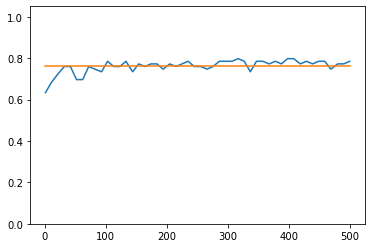

Recall mean:0.7617721518987343
f1 score:0.743455497382199
[[76 24]
 [25 71]]


In [7]:
#Metrics 
plt.plot(K_list, recall)
mean_rec = recall.mean()
plt.plot(K_list, mean_rec*np.ones_like(K_list))
plt.ylim([0, 1.05])
plt.show()
y_pred= rf.predict(X_test)
cm= confusion_matrix(y_pred,y_test)
print('Recall mean:{}'.format(mean_rec))
print('f1 score:{}'.format(f1_score(y_pred, y_test)))
print(cm)

In [8]:
#Validation of final model

from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True)
scores = [] 
for train_idx, val_idx in kf.split(X):
    X_train_k, y_train_k = X[train_idx], y[train_idx]
    X_val_k, y_val_k = X[val_idx], y[val_idx]
    rf= RandomForestClassifier(n_estimators=K_opt, class_weight='balanced')
    rf.fit(X_train_k, y_train_k)
    y_pred_k= rf.predict(X_val_k)
    cm= confusion_matrix(y_val_k, y_pred_k)
    tn, fp, fn, tp = confusion_matrix(y_val_k, y_pred_k).ravel()
    recall= float(tp) / (tp + fn)
    scores.append(recall)

print('Recall mean:{}'.format(np.mean(scores)))

Recall mean:0.7963451373495003


In [9]:
#Final model
rf= RandomForestClassifier(n_estimators=K_opt, bootstrap=True, class_weight='balanced_subsample')
rf.fit(X_train, y_train)
y_pred= rf.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
recall= float(tp) / (tp + fn)
f1score= f1_score(y_pred, y_test)
print('Recall:{}'.format(recall))
print('f1:{}'.format(f1score))

Recall:0.7368421052631579
f1:0.7650273224043714


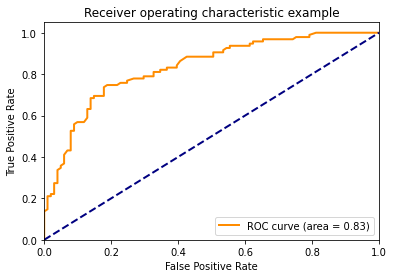

In [10]:
#ROC curve 
y_score= rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

#Graphic  
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()